In [0]:
!wget https://www.dropbox.com/s/h1n73cw33no99mz/data.pth

--2020-03-25 00:29:50--  https://www.dropbox.com/s/h1n73cw33no99mz/data.pth
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/h1n73cw33no99mz/data.pth [following]
--2020-03-25 00:29:51--  https://www.dropbox.com/s/raw/h1n73cw33no99mz/data.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc07b66ceb4c0504c152608fd510.dl.dropboxusercontent.com/cd/0/inline/A0gs5Ye64a_1nXV-kyNtKEJPVCG8a4wQwOGAxZ0P9z8QsTHXB1iSqbYgO-C2YWQV0imzJCyl3OrXpRGo0MpUmX0Qw76R34dccqZGJ7Vy0Ygi9yGe1FQ_-Tt2vd4jm4Dso-M/file# [following]
--2020-03-25 00:29:51--  https://uc07b66ceb4c0504c152608fd510.dl.dropboxusercontent.com/cd/0/inline/A0gs5Ye64a_1nXV-kyNtKEJPVCG8a4wQwOGAxZ0P9z8QsTHXB1iSqbYgO-C2YWQV0imzJCyl3OrXpRGo0MpUmX0Qw76R34dccqZGJ7Vy0Ygi9yGe1FQ_-Tt2vd4jm4

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from PIL import Image
import random
random.seed(7)
torch.manual_seed(7)
torch.cuda.manual_seed(7)
np.random.seed(7)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [0]:

train_x, train_y, dev_x, dev_y, test_x = torch.load('data.pth')

print('Training size:', train_x.shape, train_y.shape)
print('Development size:', dev_x.shape, dev_y.shape)
print('Test size:', test_x.shape)




Training size: (45000, 3, 32, 32) (45000,)
Development size: (5000, 3, 32, 32) (5000,)
Test size: (10000, 3, 32, 32)


In [0]:
img_tran_train = transforms.Compose([
 	 transforms.RandomHorizontalFlip(p=0.5),
	 transforms.RandomVerticalFlip(p=0.5),
   transforms.ToTensor()
])

In [0]:
for i in range(len(train_x)):
  if random.randint(0,1):
    image = Variable(torch.from_numpy(train_x[i]))
    image = torch.unsqueeze(image.permute(1, 2, 0), 0)
    image  = image.detach().cpu().numpy().squeeze()   
    img = Image.fromarray(image.astype('uint8')).convert('RGB')
    image = img_tran_train(img)
    train_x[i] = np.array(image)

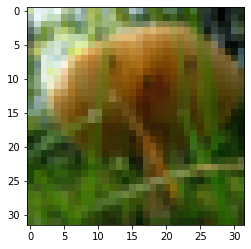

In [0]:

sample_num =random.randint(1,len(train_x))
image = train_x[sample_num]
image_ = Variable(torch.from_numpy(image))
image_ = torch.unsqueeze(image_.permute(1, 2, 0), 0)
plt.imshow(image_.detach().cpu().numpy().squeeze())

In [0]:
def normalize_stats_image_by_image(images):
  mean = images.mean(axis=(1,2), keepdims=True)
  stdev = images.std(axis=(1,2), keepdims=True)
  return (images - mean) / (images.max() - images.min())
  
train_images = normalize_stats_image_by_image(train_x)
dev_images = normalize_stats_image_by_image(dev_x)
test_images = normalize_stats_image_by_image(test_x)

In [0]:
trx = Variable(torch.from_numpy(train_images))
dx = Variable(torch.from_numpy(dev_images))
tex = Variable(torch.from_numpy(test_images))
print(trx.shape)

torch.Size([45000, 3, 32, 32])


In [0]:
torch.cuda.is_available()

True

In [0]:
torch.cuda.empty_cache() 

In [0]:


class BasicBlock(nn.Module):

    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )
        
    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class BottleNeck(nn.Module):

    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )
        
    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))
    
class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=100):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):

        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        
        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output 

def resnet18():

    return ResNet(BasicBlock, [2, 2, 2, 2])

def resnet34():

    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():

    return ResNet(BottleNeck, [3, 4, 6, 3])

def resnet101():

    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():

    return ResNet(BottleNeck, [3, 8, 36, 3])


In [0]:
model = resnet34()# myCNN()
model.cuda()
#x = torch.randn(100,3,32,32)
#print(model(Variable(x).cuda()).size())
#print(model.parameters)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2_x): Sequential(
    (0): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

In [0]:
def train_step(batch_size=128):
  
  model.train()

  input_batch, label_batch = batch(batch_size, training=True)
  #print(input_batch)
  output_batch = model(input_batch)
  #print(output_batch)
  loss = F.cross_entropy(output_batch, label_batch)
  train_loss = loss.item()
  _, pred_batch = torch.max(output_batch, dim=1)
  error_rate = 1.0 - (pred_batch == label_batch).float().mean()
  #correct = pred_batch.eq(output_batch).cpu().sum()
  #error_rate =1.0 - correct

  optimizer.zero_grad()
  loss.backward()
  
  optimizer.step()
  
  return train_loss, error_rate.item()#loss.item(), error_rate.item()

In [0]:
def val(batch_size=100):
  
  model.eval()
  input_batch, label_batch = batch(batch_size, training=False)
  output_batch = model(input_batch)

  loss = criterion(output_batch, label_batch)
  test_loss = loss.item()
  #print(loss)
  _, pred_batch = torch.max(output_batch, dim=1)
  error_rate = 1.0 - (pred_batch == label_batch).float().mean()
  #correct = pred_batch.eq(output_batch).cpu().sum()
  #error_rate =1.0 - correct
  return test_loss, error_rate.item() #loss.item(), error_rate.item()

In [0]:


def batch(batch_size, training=True):
  """Create a batch of examples.
  
  This creates a batch of input images and a batch of corresponding
  ground-truth labels. We assume CUDA is available (with a GPU).
  
  Args:
    batch_size: An integer.
    training: A boolean. If True, grab examples from the training
      set; otherwise, grab them from the validation set.
  
  Returns:
    A tuple,
    input_batch: A Variable of floats with shape
      [batch_size, 1, height, width]
    label_batch: A Variable of ints with shape
      [batch_size].
  """
  if training:
    random_ind = np.random.choice(train_images.shape[0], size=batch_size, replace=False)
    input_batch = train_images[random_ind]
    label_batch = train_y[random_ind]
  else:
    input_batch = dev_images[:batch_size]
    label_batch = dev_y[:batch_size]
  
  #input_batch = input_batch[:, np.newaxis, :, :]
  
  input_batch = torch.tensor(input_batch, requires_grad=False, device='cuda').type(torch.FloatTensor).cuda()
  label_batch = torch.tensor(label_batch, requires_grad=False, device='cuda')
  #print(input_batch.shape)
  return input_batch, label_batch


Step     1: Obtained a best validation error of 0.980.
Step    27: Obtained a best validation error of 0.970.
Step    69: Obtained a best validation error of 0.960.
Step    74: Obtained a best validation error of 0.940.
Step   252: Obtained a best validation error of 0.930.
Step   265: Obtained a best validation error of 0.920.
Step   307: Obtained a best validation error of 0.910.
Step   309: Obtained a best validation error of 0.900.
Step   321: Obtained a best validation error of 0.880.
Step   471: Obtained a best validation error of 0.870.
Step   502: Obtained a best validation error of 0.850.
Step   503: Obtained a best validation error of 0.840.
Step   504: Obtained a best validation error of 0.830.
Step   764: Obtained a best validation error of 0.820.
Step   918: Obtained a best validation error of 0.810.
Step   919: Obtained a best validation error of 0.800.
Step   920: Obtained a best validation error of 0.790.
Step  1036: Obtained a best validation error of 0.780.
Step  1224

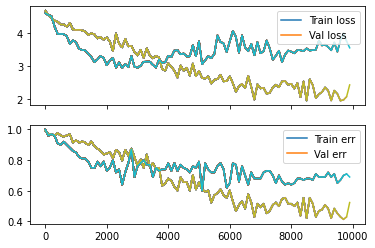

In [17]:

# Let's make sure we always start from scratch (that is,
# without starting from parameters from a previous run).
#for module in model.children():
  #module.reset_parameters()

info = []
fig, ax = plt.subplots(2, 1, sharex=True)
num_steps = 10000
num_steps_per_val = 100
best_val_err = 1.0
for step in range(num_steps):
  train_loss, train_err = train_step()
  val_loss, val_err = val()
  if val_err < best_val_err:
    best_val_err = val_err
    print('Step {:5d}: Obtained a best validation error of {:.3f}.'.format(step, best_val_err))
  if step % num_steps_per_val == 0:
    #print(val_loss)
    info.append([step, train_loss, val_loss, train_err, val_err])
    x, y11, y12, y21, y22 = zip(*info)
    ax[0].plot(x, y11, x, y12)
    ax[0].legend(['Train loss', 'Val loss'])
    ax[1].plot(x, y21, x, y22)
    ax[1].legend(['Train err', 'Val err'])
    #ax[1].set_ylim([0.0, 0.25])
    

In [0]:

from typing import List
def write_prediction(prediction: List[int], filename: str,t):
    with open(filename, 'a') as fp:
        if t == 0:
          print('Id,Category', file=fp)
        
        for i, pred in enumerate(prediction):
          print(f'{t},{pred}', file=fp)

In [0]:
test = torch.tensor(test_images, requires_grad=False, device='cuda').type(torch.FloatTensor).cuda()
for t in range(len(test)):
  #print(test[t:t+1,:,:,:])
  outputs = model(test[t:t+1,:,:,:])
  _,prediction = torch.max(outputs.data, 1)
  write_prediction(prediction, 'output.csv',t)

In [0]:
from google.colab import files

files.download('output.csv')

In [0]:
output = model(test[0:2,:,:,:])
_,prediction = torch.max(output.data, 1)
print(prediction)